# US Household displacement in disasters: Naive Bayes

## General background

In 2022, more than 1.3% of the adult population (3.3M) in the United States was displaced by disasters [(AP News)](https://apnews.com/article/natural-disasters-indiana-florida-climate-and-environment-0bfdab41b233feba55e08382a0594258).

This notebook investigates the public use files (PUF) from the [**United States Household Pulse Survey**](https://www.census.gov/programs-surveys/household-pulse-survey.html). Information regarding displacement following disasters was introduced from Week 52. The availability of microdata allows an exploration of various factors that may be associated longer displacement durations.


## Notebook scope
This notebook fits a logistic regression model to the HPS dataset.

## Configuration

* Load dependencies

* Load configuration for figures/plotting

* Load custom methods to process data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

os.chdir(os.path.join(os.getcwd(), "..", ".."))

from parsers.parse_data_dictionary import parse_data_dictionary
from parsers.parse_puf_files import parse_puf_files, custom_puf_handling
from plotters.plot_metrics import plot_roc_auc, plot_confusion_matx
from util.plot import plot_config
from plotters.plot_trees import plot_feature_importance
from util.data import expand_train_test_split_by_weights

# Add dependencies - running the model
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
# Add dependencies - evaluating the model
from sklearn.metrics import classification_report

plot_config(theme="derisc")

Using theme: derisc


## Read and parse data

* Read a data dictionary (`data_dict`), which helps parse the variables available in the PUF and provides human-friendly string descriptions

* Read multiple PUF files and combine into one DataFrame (`puf`)

* Displace the overall displacement rate based on the data (with household weights applied)

In [2]:
# Read data dictionary
data_folder = os.path.join(os.getcwd(), "data")
data_dict_path = os.path.join(data_folder, "Data_Dictionary.xlsx")
data_dict = parse_data_dictionary(data_dict_path, drop_bad=True).set_index('Variable')

# Print available factors
print(f"Potentially relevant factors for processing: {data_dict.index.values}")

# Preview
data_dict.head(5)

Potentially relevant factors for processing: ['TBIRTH_YEAR' 'RHISPANIC' 'RRACE' 'EEDUC' 'MS' 'GENID_DESCRIBE'
 'THHLD_NUMPER' 'THHLD_NUMKID' 'THHLD_NUMADLT' 'KIDS_LT5Y' 'KIDS_5_11Y'
 'KIDS_12_17Y' 'TENROLLPUB' 'TENROLLPRV' 'TENROLLHMSCH' 'ANYWORK'
 'KINDWORK' 'SETTING' 'TWDAYS' 'FRMLA_YN' 'ND_DISPLACE' 'ND_TYPE1'
 'ND_TYPE2' 'ND_TYPE3' 'ND_TYPE4' 'ND_TYPE5' 'ND_HOWLONG' 'ND_DAMAGE'
 'ND_FDSHRTAGE' 'ND_WATER' 'ND_ELCTRC' 'ND_UNSANITARY' 'ANXIOUS' 'WORRY'
 'INTEREST' 'DOWN' 'SEEING' 'HEARING' 'REMEMBERING' 'MOBILITY' 'SELFCARE'
 'UNDERSTAND' 'TENURE' 'TRENTAMT' 'LIVQTRRV' 'INCOME' 'EST_ST' 'EST_MSA'
 'HWEIGHT' 'REGION']


,Type,Name,Values,Conversion
Variable,,,,
TBIRTH_YEAR,Discrete,Birth year,1934 to 2004,{'1934 to 2004': '1934 to 2004'}
RHISPANIC,Nominal,Hispanic origin,1) No\n2) Yes,"{1: 'No', 2: 'Yes'}"
RRACE,Nominal,Race,1) White\n2) Black\n3) Asian\n4) Other/Mixed,"{1: 'White', 2: 'Black', 3: 'Asian', 4: 'Other..."
EEDUC,Ordinal,Educational attainment,1) Less than high school\n2) Some high school\...,"{1: 'Less than high school', 2: 'Some high sch..."
MS,Nominal,Marital status,1) Now married\n2) Widowed\n3) Divorced\n4) Se...,"{1: 'Now married', 2: 'Widowed', 3: 'Divorced'..."


In [3]:
# Locate folder where data is stored
puf_folder = r"/Users/nicolepaul/Library/CloudStorage/Dropbox/Nicole's PhD project/4. Data/2. US Household Pulse Survey/PUF" # Save the zipped PUF files from the HPS in a known location and reference the path here
assert os.path.exists(puf_folder), f"Could not locate {puf_folder}"

# Locate folder to write any outputs
img_folder = os.path.join("img")

# Read PUF files
puf = parse_puf_files(puf_folder)

# Preview
print(f"Found {puf.shape[0]:,.0f} records")
puf.head(5)

Setting bad_vals ([-88, -99]) = NaN
Found 1,326,503 records


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,ND_MED,HLTH_MHCHLD1,HLTH_MHCHLD2,HLTH_MHCHLD3,HLTH_MHCHLD4,HLTH_MHCHLD5,HLTH_MHCHLD6,HLTH_MHCHLD7,HLTH_MHCHLD8,HLTH_MHCHLD9
0,V520000001,52.0,44,NaN,1,297.631871,1123.798115,1968,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V520000002,52.0,5,NaN,2,544.644346,1009.342253,1959,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V520000003,52.0,48,NaN,2,187.423803,346.468149,1946,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V520000004,52.0,11,47900.0,2,116.768607,199.033089,1984,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V520000005,52.0,28,NaN,2,700.047941,1329.911657,1963,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Read in area data
area_path = os.path.join(data_folder, "Area_Attributes.xlsx")
msa_field, state_field = "EST_MSA", "EST_ST"
area_cats = [msa_field, state_field]
areas = dict.fromkeys(area_cats)
for area_cat in area_cats:
    areas[area_cat] = pd.read_excel(area_path, sheet_name=area_cat).set_index(area_cat)

# Read and append area dictionary
dict_sheet = "Data Dictionary"
area_dict = pd.read_excel(area_path, sheet_name=dict_sheet).set_index('Variable')
data_dict = pd.concat([data_dict, area_dict], axis=0)

# Determine columns to be added
all_cols = list(map(lambda x: list(x.columns), [areas[area_cat] for area_cat in area_cats]))
area_cols  = list(set.union(*map(set, all_cols)))
print(f"Will add area attributes: {area_cols}")

# Get unique values
msas = puf[msa_field].dropna().unique()
states = puf[state_field].dropna().unique()

# Append area attributes
puf[area_cols] = ''
for col in area_cols:
    if col in areas[state_field].columns:
        for state in states:
            idx = puf[state_field] == state
            puf.loc[idx, col] = areas[state_field].loc[state, col]
    if col in areas[msa_field].columns:
        for msa in msas:
            jdx = puf[msa_field] == msa
            puf.loc[jdx, col] = areas[msa_field].loc[msa, col]

# Preview
puf.head(5)

Will add area attributes: ['VACANCY_RENTAL_2022', 'POPULATION_2020', 'SATISFACTION_HOME_2021', 'VACANCY_HOMEOWNER_2022', 'UNEMPLOYMENT_2022', 'STATE', 'DISASTERS_2021-2023', 'METRO_AREA', 'RATE_HOMEOWNER_2022', 'POPULATION_TREND_10YR', 'SATISFACTION_NGBD_2021']


/Users/nicolepaul/Code/hps-test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/nicolepaul/Code/hps-test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/Users/nicolepaul/Code/hps-test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/nicolepaul/Code/hps-test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,POPULATION_2020,SATISFACTION_HOME_2021,VACANCY_HOMEOWNER_2022,UNEMPLOYMENT_2022,STATE,DISASTERS_2021-2023,METRO_AREA,RATE_HOMEOWNER_2022,POPULATION_TREND_10YR,SATISFACTION_NGBD_2021
0,V520000001,52.0,44,NaN,1,297.631871,1123.798115,1968,2,1,...,1096345.0,NaN,0.6,3.2,Rhode Island,6.0,,65.8,0.040216,NaN
1,V520000002,52.0,5,NaN,2,544.644346,1009.342253,1959,2,1,...,3014195.0,NaN,1.5,3.3,Arkansas,25.0,,66.8,0.031565,NaN
2,V520000003,52.0,48,NaN,2,187.423803,346.468149,1946,2,1,...,29232474.0,0.884599,0.8,3.9,Texas,277.0,,63.6,0.15809,NaN
3,V520000004,52.0,11,47900.0,2,116.768607,199.033089,1984,2,1,...,6366679,0.921331,0.6,3.0,District of Columbia,0.0,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",66.2,0.121192,0.928345
4,V520000005,52.0,28,NaN,2,700.047941,1329.911657,1963,2,1,...,2958141.0,NaN,0.6,3.9,Mississippi,156.0,,73.1,-0.004177,NaN


In [5]:
# Estimate percentage of households that were displaced
criteria = (puf.ND_DISPLACE == 1)
n_households = puf.HWEIGHT.sum()
n_displaced_households = puf[criteria].HWEIGHT.sum()
print(f"Estimated a displacement rate of {(n_displaced_households/n_households):.2%}")

Estimated a displacement rate of 1.12%


## Custom data processing

* Binning continuous/discrete factors to be ordinal

* Creating factors to represent protracted displacement and return

* Creating dummy variables for nominal data

In [6]:
# Implement custom data handling
puf, data_dict = custom_puf_handling(puf, data_dict)

# Export processed data subset for dashboard
criteria = (puf.ND_DISPLACE == 1) 
# puf[criteria].to_csv("displaced_households.csv", index=False)

# Preview
puf[criteria].head(5)

Added new columns: ['HAZARD_TYPE', 'AGE_BIN', 'HH_BIN', 'RENT_BIN', 'INCOME_PER', 'DWELLTYPE', 'TENURE_STATUS', 'RMINORITY', 'SCHOOLENROLL', 'LIVQTR_OTHER', 'LIVQTR_MOBILE', 'LIVQTR_SINGLE', 'LIVQTR_MULTI', 'RETURNED', 'PROTRACTED', 'RECOVERY', 'PHASE', 'PHASE_RETURN', 'RETURN_1', 'RETURN_2', 'RETURN_3']


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,LIVQTR_SINGLE,LIVQTR_MULTI,RETURNED,PROTRACTED,RECOVERY,PHASE,PHASE_RETURN,RETURN_1,RETURN_2,RETURN_3
7,V520000008,52.0,12,NaN,2,10141.479843,18633.438797,1994,2,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
70,V520000071,52.0,4,NaN,4,3504.757175,6529.976342,1950,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
108,V520000109,52.0,42,37980.0,1,801.677778,2856.430494,1972,2,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
110,V520000111,52.0,22,NaN,2,895.045567,1686.648972,1987,2,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
382,V520000383,52.0,42,NaN,1,4276.797681,7619.255295,1958,2,1,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Split data and apply weights

# Feature selection
dependent = "PHASE_RETURN" # options: RETURNED, PROTRACTED, RETURN_1, RETURN_2, RETURN_3, ND_HOWLONG, PHASE
independents = ['ND_DAMAGE',
                'ND_WATER', 'ND_ELCTRC', 'ND_UNSANITARY', 'ND_FDSHRTAGE', 
                'TENURE_STATUS', # 'TENURE',
                'HH_BIN', 'SCHOOLENROLL',
                'INCOME_PER', # 'INCOME',
                'RRACE',
                'DWELLTYPE', # 'LIVQTR_OTHER', 'LIVQTR_MOBILE, 'LIVQTR_SINGLE', 'LIVQTR_MULTI', # 'LIVQTRRV',
                'HAZARD_TYPE',
                'UNEMPLOYMENT_2022',
                'DISASTERS_2021-2023',
                # 'SATISFACTION_NGBD_2021',
                # 'SATISFACTION_HOME_2021',
                'RATE_HOMEOWNER_2022',
                'VACANCY_HOMEOWNER_2022', 'VACANCY_RENTAL_2022', 'POPULATION_TREND_10YR', # 'POPULATION_2020',
                'MS', 'RHISPANIC', # 'RMINORITY',
                'ANYWORK', 'AGE_BIN','EEDUC', 'MOBILITY', # 'RENT_BIN'
               ]
weights = "HWEIGHT"

# Choose class names
class_names = data_dict.loc[dependent, 'Conversion']

# Get data subset
data = puf[criteria].dropna(subset=[dependent]+independents).copy()
n_all, n_safe = puf[criteria].shape[0], data.shape[0]
print(f"Dropping {(n_all-n_safe):,.0f} rows with NaN values of {n_all:,.0f} records ({(n_safe/n_all):.1%} retained)")

# Arrange data
y = data[dependent] # Target variable
X = data[independents] # Features
w = data[weights].div(50).astype(int) # Weights
n_independents = len(independents)

# Split dataset into training set and test set
seed = 34
p_testing = 0.2
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=p_testing, random_state=seed, stratify=y) 

# Expand by weights
from util.data import expand_train_test_split_by_weights
X_train, y_train = expand_train_test_split_by_weights(X_train, y_train, w_train)
X_test, y_test = expand_train_test_split_by_weights(X_test, y_test, w_test)

# Apply class balancing technique
method = "SMOTE" # Options: SMOTE, invHist
sample_weight = None
if method == "SMOTE":
  from imblearn.over_sampling import SMOTE
  smote_seed = 3
  sm = SMOTE(random_state=smote_seed, sampling_strategy='not majority')
  X_train, y_train = sm.fit_resample(X_train, y_train)
elif method == "invHist":
  from sklearn.utils.class_weight import compute_sample_weight
  sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)
else:
  raise NameError(f'Method of {method} not known')


Dropping 2,146 rows with NaN values of 11,715 records (81.7% retained)


## Support vector machine


In [8]:
# # Create SVM classifer object
# kernel = 'linear' # options: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
# clf = svm.SVC(kernel=kernel)

# # Train Decision Tree Classifer
# model = clf.fit(X_train, y_train, sample_weight=sample_weight)

# # Predict the response for test dataset
# y_pred = model.predict(X_test)

# # Test predictions
# print(classification_report(y_test, y_pred, target_names=class_names.values()))

# # Create the confusion matrix
# fig, axs = plot_confusion_matx(y_test, y_pred, class_names)
# plt.show()

# # Create ROC/AUC plot
# fig, ax = plt.subplots(figsize=(4,3.5))
# plot_roc_auc(model, X_test, y_test, class_names, ax)
# plt.show()

# # Estimate and plot feature importance
# from sklearn.inspection import permutation_importance
# imps = permutation_importance(model, X_test, y_test)
# feature_importance = imps.importances_mean
# # Create a series containing feature importances from the model and feature names from the training data
# fig, ax = plt.subplots(figsize=(8,4.5))
# plot_feature_importance(np.abs(feature_importance), independents, data_dict, ax, ylim=(0,0.1))
# fig.tight_layout()
# plt.show()

/Users/nicolepaul/Code/hps-test/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                 precision    recall  f1-score   support

Emergency phase       0.89      0.79      0.84     58324
 Recovery phase       0.39      0.44      0.41     16630
   Not returned       0.38      0.54      0.45     10561

       accuracy                           0.69     85515
      macro avg       0.55      0.59      0.57     85515
   weighted avg       0.73      0.69      0.71     85515



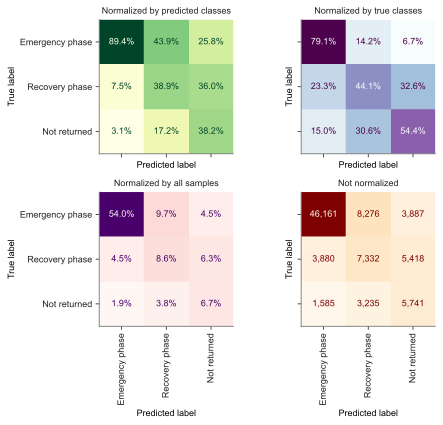

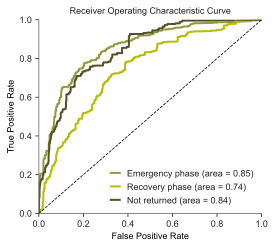

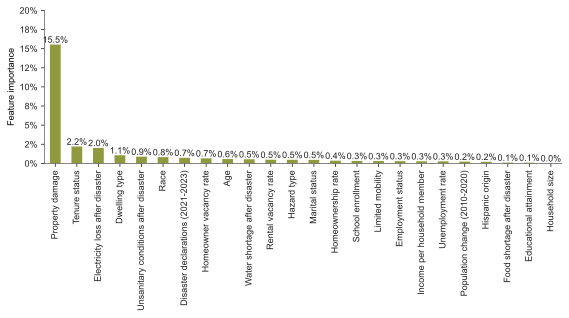

In [12]:
# Create SVM classifer object

# NOTE: svm.SVC() did not compute in over 130 hours, whereas LinearSVC completes in seconds
# Read more at: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
clf = svm.LinearSVC()

# Train Decision Tree Classifer
model = clf.fit(X_train, y_train, sample_weight=sample_weight)

# Predict the response for test dataset
y_pred = model.predict(X_test)

# Test predictions
print(classification_report(y_test, y_pred, target_names=class_names.values()))

# Create the confusion matrix
fig, axs = plot_confusion_matx(y_test, y_pred, class_names)
plt.show()

# Create ROC/AUC plot
fig, ax = plt.subplots(figsize=(4,3.5))
plot_roc_auc(model, X_test, y_test, class_names, ax)
plt.show()

# Estimate and plot feature importance
from sklearn.inspection import permutation_importance
imps = permutation_importance(model, X_test, y_test)
feature_importance = imps.importances_mean
# Create a series containing feature importances from the model and feature names from the training data
fig, ax = plt.subplots(figsize=(8,4.5))
plot_feature_importance(np.abs(feature_importance), independents, data_dict, ax, ylim=(0,0.2))
fig.tight_layout()
plt.show()